In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import yfinance as yf
import sys
sys.path.append('../utils')  # manually add the utils folder
from optimize_portfolio import optimize_portfolio, portfolio_performance


In [16]:
# Load your portfolio tickers
portfolio = pd.read_csv("../data/sample-portfolio.csv")  # adjust path if needed
tickers = portfolio["Ticker"].tolist()
real_weights = portfolio['Weight'].values

tickers = portfolio['Ticker'].tolist()
start_date = '2022-01-01'
end_date = '2025-06-30'

data = yf.download(tickers, start=start_date, end=end_date)['Close']

returns = data.pct_change().dropna()
returns.head()


C:\Users\sheeb\AppData\Local\Temp\ipykernel_14412\1320812224.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  10 of 10 completed



Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,MSFT,NVDA,PEP,UNH,V
Date,,,,,,,,,,
2022-01-04,-0.012692,-0.016916,-0.004083,-0.002681,0.037910,-0.017147,-0.027589,0.001445,-0.022657,0.004652
2022-01-05,-0.026600,-0.018893,-0.045876,0.006663,-0.018282,-0.038388,-0.057562,0.003406,-0.002465,-0.011058
2022-01-06,-0.016693,-0.006711,-0.000200,-0.003426,0.010624,-0.007902,0.020794,0.000230,-0.040924,-0.001136
2022-01-07,0.000988,-0.004288,-0.005303,0.013517,0.009908,0.000510,-0.033040,0.001266,-0.023528,-0.012696
2022-01-10,0.000116,-0.006570,0.012061,-0.004944,0.000957,0.000732,0.005615,0.000517,0.013955,-0.023000


In [17]:
mean_returns = returns.mean() * 252  # annualized
cov_matrix = returns.cov() * 252    # annualized
tickers = returns.columns

# Max Sharpe Portfolio
opt_weights = optimize_portfolio(returns, method='max_sharpe')

# Display Weights
# Create a DataFrame for better readability
opt_weights_df = pd.DataFrame({
    "Ticker": tickers,
    "Weight": opt_weights
})

# Optionally filter out very small weights
opt_weights_df = opt_weights_df[opt_weights_df["Weight"] > 0.01]

# Sort by weight (optional)
opt_weights_df = opt_weights_df.sort_values("Weight", ascending=False)

# Print the DataFrame
print(opt_weights_df)




  Ticker    Weight
4    JPM  0.490160
6   NVDA  0.404635
9      V  0.071930
3    JNJ  0.033274


In [18]:
equal_weights = np.repeat(1 / len(tickers), len(tickers))

# Compute performance (all annualized)
real_ret, real_vol, real_sharpe = portfolio_performance(real_weights, mean_returns, cov_matrix)
opt_ret, opt_vol, opt_sharpe = portfolio_performance(opt_weights, mean_returns, cov_matrix)
eq_ret, eq_vol, eq_sharpe = portfolio_performance(equal_weights, mean_returns, cov_matrix)

print(f"Real Sharpe: {real_sharpe:.2f}, Optimized Sharpe: {opt_sharpe:.2f}")
print(f"Equal Sharpe: {eq_sharpe:.2f}")



Real Sharpe: 0.67, Optimized Sharpe: 1.24
Equal Sharpe: 0.72


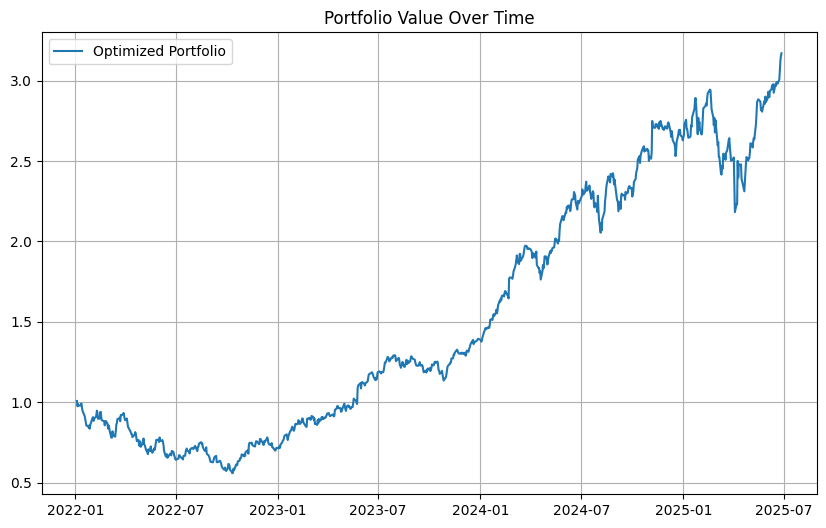

In [19]:
def portfolio_growth(returns_df, weights):
    portfolio_returns = returns_df.dot(weights)
    cum_returns = (1 + portfolio_returns).cumprod()
    return cum_returns

opt_cum = portfolio_growth(returns, opt_weights)

plt.figure(figsize=(10, 6))
plt.plot(opt_cum, label="Optimized Portfolio")
plt.title("Portfolio Value Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
def simulate_portfolios(returns_df, num_portfolios=100000):
    mean_returns = returns_df.mean() * 252
    cov_matrix = returns_df.cov() * 252  # Annualize the covariance matrix
    num_assets = len(mean_returns)

    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        ret, vol, sharpe = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0, i] = ret
        results[1, i] = vol
        results[2, i] = sharpe

    return results

# ...existing code...
# Create a DataFrame for better readability
opt_weights_df = pd.DataFrame({
    "Ticker": tickers,
    "Weight": opt_weights
})

# Optionally filter out very small weights
opt_weights_df = opt_weights_df[opt_weights_df["Weight"] > 0.01]

# Sort by weight (optional)
opt_weights_df = opt_weights_df.sort_values("Weight", ascending=False)

# Print the DataFrame
print(opt_weights_df)
# ...existing code...
opt_ret, opt_vol, opt_sharpe = portfolio_performance(opt_weights, mean_returns, cov_matrix)
print(f"Optimized Return: {opt_ret:.2%}, Volatility: {opt_vol:.2%}, Sharpe: {opt_sharpe:.2f}")


print("Tickers:", tickers)
print("Returns columns:", returns.columns.tolist())
print("Optimized weights:", opt_weights)



  Ticker    Weight
4    JPM  0.490160
6   NVDA  0.404635
9      V  0.071930
3    JNJ  0.033274
Optimized Return: 38.03%, Volatility: 30.76%, Sharpe: 1.24
Tickers: Index(['AAPL', 'AMZN', 'GOOGL', 'JNJ', 'JPM', 'MSFT', 'NVDA', 'PEP', 'UNH',
       'V'],
      dtype='object', name='Ticker')
Returns columns: ['AAPL', 'AMZN', 'GOOGL', 'JNJ', 'JPM', 'MSFT', 'NVDA', 'PEP', 'UNH', 'V']
Optimized weights: [1.88770451e-17 1.55854508e-16 0.00000000e+00 3.32741155e-02
 4.90160188e-01 0.00000000e+00 4.04635433e-01 0.00000000e+00
 2.44880392e-16 7.19302629e-02]


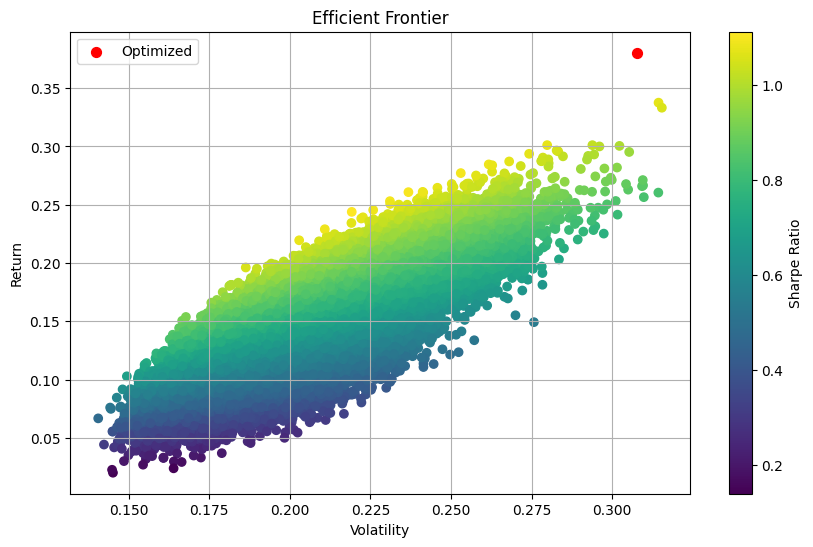

In [21]:
sim_results = simulate_portfolios(returns)

plt.figure(figsize=(10, 6))
plt.scatter(sim_results[1], sim_results[0], c=sim_results[2], cmap='viridis')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(opt_vol, opt_ret, c='red', s=50, label='Optimized')
plt.legend()
plt.grid(True)
plt.show()